# The original motivation behind anchor boxes

[W]e introduce novel “anchor” boxes that serve as references at multiple scales and aspect ratios.

Our design of anchors presents a novel scheme
for addressing multiple scales (and aspect ratios). As shown in Figure 1, there have been two popular ways for multi-scale predictions. The first way is based on image/feature pyramids, e.g., in DPM [8] and CNN- based methods [9], [1], [2]. The images are resized at multiple scales, and feature maps (HOG [8] or deep convolutional features [9], [1], [2]) are computed for each scale (Figure 1(a)). This way is often useful but is time-consuming. The second way is to use sliding windows of multiple scales (and/or aspect ratios) on the feature maps. For example, in DPM [8], models of different aspect ratios are trained separately using different filter sizes (such as 5×7 and 7×5). If this way is used to address multiple scales, it can be thought of as a “pyramid of filters” (Figure 1(b)). The second way is usually adopted jointly with the first way [8].

As a comparison, our anchor-based method is built
on a pyramid of anchors, which is more cost-efficient. Our method classifies and regresses bounding boxes with reference to anchor boxes of multiple scales and aspect ratios. It only relies on images and feature maps of a single scale, and uses filters (sliding win- dows on the feature map) of a single size. We show by experiments the effects of this scheme for addressing multiple scales and sizes (Table 8). 

Because of this multi-scale design based on anchors,
we can simply use the convolutional features com- puted on a single-scale image, as is also done by the Fast R-CNN detector [2]. The design of multi- scale anchors is a key component for sharing features without extra cost for addressing scales.

[TODO: Add the sizes/scales used in original]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

> An anchor box is essentially a starting point that the network learns to transform into a bounding box for an object. 

In [22]:
#[TODO: example with real imagee]

An anchor is centered at the sliding window in question, and is associated with a scale and aspect ratio (Figure 3, left). By default we use 3 scales and 3 aspect ratios, yielding k = 9 anchors at each sliding position.

> Each pixel in the input feature map corresponds to an anchor box. Here we will adapt FaceBook's MRCNN benchmark anchor generation code. First we define a single `anchor` with dimensions $[x_1, y_1, x_2, y_2] = [0, 0, s-1, s-1]$, where $s$ is the stride of the feature map with respect to the input.

In [2]:
def generate_anchors(
    stride=16, sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.5, 1, 2)
):
    
    sizes = np.array(sizes)
    aspect_ratios = np.array(aspect_ratios)
    
    base_anchor = anchor = np.array([1, 1, stride, stride], dtype=np.float) - 1 # (1,)
    w, h, x_ctr, y_ctr =  to_whxy(base_anchor) # (1,)
    base_area = w * h
    
    widths = np.round(np.sqrt(base_area / aspect_ratios)) # (A,)
    heights = np.round(widths * aspect_ratios) # (A,)
    
    scales = sizes / stride
    widths = scales[None] * widths[:, None] # (A, S)
    heights = scales[None] * heights[:, None]  # (A, S)
    
    # Each is (A, S)
    x1 = x_ctr - 0.5 * (widths - 1)
    y1 = y_ctr - 0.5 * (heights - 1)
    x2 = x_ctr + 0.5 * (widths - 1)
    y2 = y_ctr + 0.5 * (heights - 1)
    
    anchors = np.stack([x1, y1, x2, y2], axis=-1) #(A, S, 4)
    
    return np.reshape(anchors, [-1, 4]) # (A*S, 4)

> A function to convert from $[x_1, y_1, x_2, y_2]$ to $[w, h, x_\text{centre}, y_\text{centre}]$. Note that $x_2$ and $y_2$ are *inside* the box so we need to add 1 to get the dimensions.

In [3]:
def to_whxy(anchor):
    # [..., 4]
    """Return width, height, x center, and y center for an anchor (window)."""
    w = anchor[..., 2] - anchor[..., 0] + 1
    h = anchor[..., 3] - anchor[..., 1] + 1
    x_ctr = anchor[..., 0] + 0.5 * (w - 1)
    y_ctr = anchor[..., 1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr # [...]


In [4]:
def plot_rectangle(box, ax=None):
    x1, y1, x2, y2 = box
    w, h, xc, yc = to_whxy(box)
    # -1 because box is plotted between x1 to x1 + w when we want x1 to x1 + w - 1
    ax.add_artist(plt.Rectangle(xy=(x1, y1), height=h-1, width=w-1, fill=False, color='b'))
    ax.plot(xc, yc, 'x')
    for x in [x1, x2]:
        for y in [y1, y2]:
            ax.plot(x, y, '.')
    ax.invert_yaxis();

In [5]:
anchors = generate_anchors()
to_whxy(anchors)

(array([ 46.,  92., 184., 368., 736.,  32.,  64., 128., 256., 512.,  22.,
         44.,  88., 176., 352.]),
 array([ 24.,  48.,  96., 192., 384.,  32.,  64., 128., 256., 512.,  44.,
         88., 176., 352., 704.]),
 array([7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5,
        7.5, 7.5]),
 array([7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5,
        7.5, 7.5]))

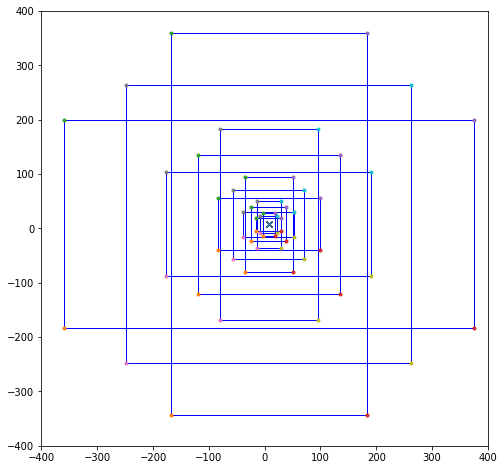

In [6]:
fig, ax = plt.subplots(1, figsize=(8,8))

for box in anchors:
    plot_rectangle(box, ax);
    plt.xlim(-400, 400)
    plt.ylim(-400, 400);

> A grid of anchors is constructed by shifting the these anchor boxes across the feature map with a shift per pixel of the stride $s$. 


In [17]:
def grid_anchors(base_anchors, stride, height, width):
    shifts_x = np.arange(0, stride, width) # (W,)
    shifts_y = np.arange(0, stride, height) # (H,)
    
    # Indexing is 'xy' by default but 'ij' in pytorch 
    # (so they reverse these in the mrcnn benchmark code)
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y) 
    
    shifts = np.stack([shifts_x, shifts_y, shifts_x, shifts_y], axis=-1) # (H, W, 4)
    
    # (H, W, 1, 4) + (1, 1, N, 4) -> (H, W, N, 4)
    anchors = shifts[..., None, :] + base_anchors[None, None]
    return anchors

 > Brief refresher on meshgrid as this can be somewhat confusing. Note that whilse`xx` corresponds to the familiar form where $x$ is from left to right and $y$ is reversed. 

In [18]:
xx, yy = np.meshgrid(np.arange(5), np.arange(7))
xx

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [19]:
yy

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6]])

> Remember also that *columns* map to $x$ and *rows* map to $y$. So to crop box $[x_1, y_1, x_2, y_2]$ from a feature map we reverse the order for slicing. Also recall that we are using the convention where $x_2$ and $y_2$ are inside the box so we slice up to $x_2 + 1$ and $y_2 + 1$.

In [21]:
def crop_box(img, box):
    x1, y1, x2, y2 = box
    return img[y1:y2+1, x1:x2+1]

In [ ]:
img = np.

We adapt RPN by replacing the single-scale feature map
with our FPN. We attach a head of the same design (3×3 conv and two sibling 1×1 convs) to each level on our feature pyramid. Because the head slides densely over all locations in all pyramid levels, it is not necessary to have multi-scale anchors on a specific level. Instead, we assign anchors of a single scale to each level. Formally, we define the an- chors to have areas of {322, 642, 1282, 2562, 5122} pixels on {P2, P3, P4, P5, P6} respectively.1 As in [29] we also use anchors of multiple aspect ratios {1:2, 1:1, 2:1} at each level.

> The step of assigning anchor boxes to a feature map involves constructing a grid of boxes corresponding to each pixel in the feature map. The anchor centres are shifted across the feature map where the shift per pixel corresponds to the stride of the feature map relative to the input. Each successively smaller feature map has a coarser grid of anchor boxes but also has a larger receptive field. It helps to think of the downscaled feature map as a coarse grid across the image.

In [61]:
def plot_dot_grid(ax, n, stride=1):
    x = np.arange(0, n, stride)
    x, y = np.meshgrid(x, x)
    ax.plot(x.ravel(), y.ravel(), '.')

> Grids that are succesively smaller ...

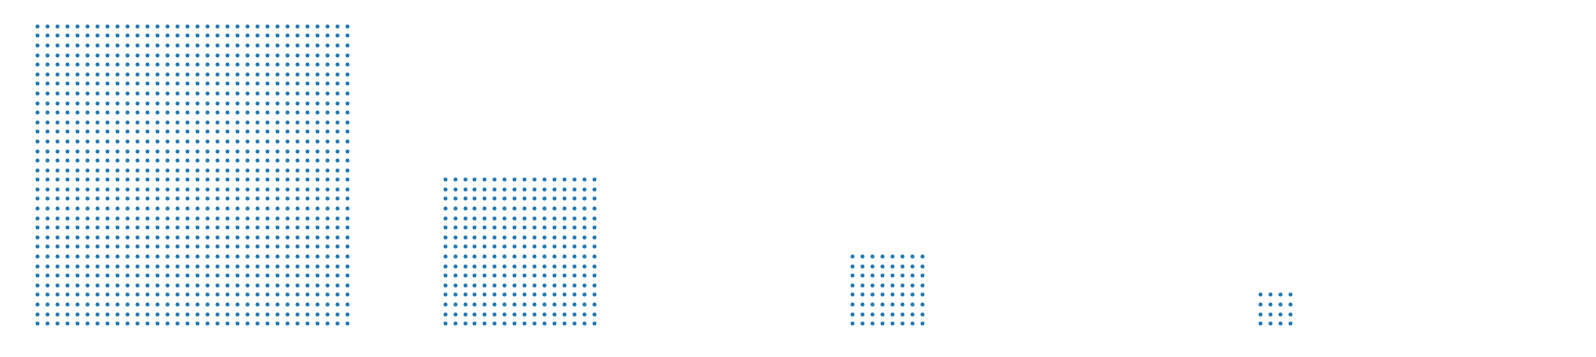

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(28, 6))
for i, ax in enumerate(axes):
    plot_dot_grid(ax, 32//(2**i), 1)
    ax.set_xlim(-1, 33)
    ax.set_ylim(-1, 33)
    ax.axis('off')

> ... can be viewed as successively coarser grids

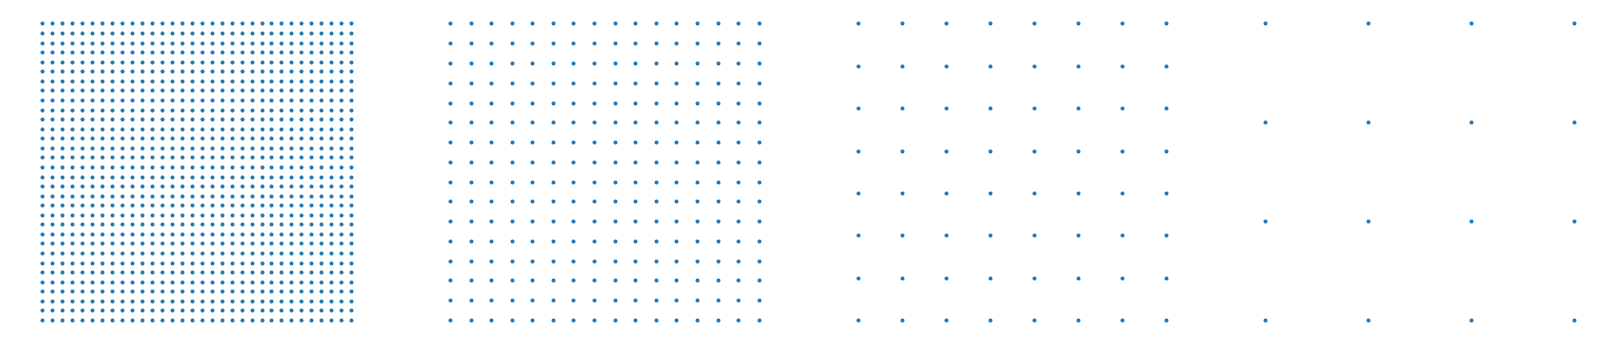

In [72]:
fig, axes = plt.subplots(1, 4, figsize=(28, 6))
for i, ax in enumerate(axes):
    plot_dot_grid(ax, 32, (2**i))
    ax.axis('off')

In [74]:
def pyramid_anchors(strides, sizes, aspect_ratios):
    if len(strides) != len(sizes):
        raise ValueError('For FPN number of strides and sizes must be the same')
    anchors = [generate_anchors(stride, size, aspect_rations) for stride, size in zip(strides, sizes)]
    return anchors